In [1]:
import numpy as np
import gymnasium as gym
from gymnasium.spaces import MultiBinary
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.logger import configure
import os

# 스마트 팩토리 환경 생성
class SmartFactoryEnvRNN(gym.Env):
    def __init__(self, n_machines=324, energy_limit=648):
        super(SmartFactoryEnvRNN, self).__init__()
        self.n_machines = n_machines
        self.energy_limit = energy_limit

        # Multi-Binary 행동 공간
        self.action_space = MultiBinary(n_machines)

        # 관찰 공간 (기계 상태 + 작동 시간)
        self.observation_space = gym.spaces.Box(
            low=0, high=1, shape=(n_machines * 2 + 1,), dtype=float
        )

        # 초기화
        self.state = None
        self.machine_runtime = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.zeros(self.n_machines * 2 + 1, dtype=float)
        self.machine_runtime = np.zeros(self.n_machines, dtype=float)
        return self.state, {}

    def step(self, action):
        # 기계 작동 시간 업데이트
        self.machine_runtime += action

        # 생산성 및 에너지 사용량 계산
        energy_usage = np.dot(np.random.uniform(1, 2, self.n_machines), action)
        productivity_factors = np.exp(-0.1 * self.machine_runtime)  # 작동 시간이 길수록 생산성 감소
        production = np.dot(np.random.uniform(1, 3, self.n_machines) * productivity_factors, action)

        # 페널티 계산
        penalty = max(0, energy_usage - self.energy_limit)
        reward = production - energy_usage - penalty

        # 상태 업데이트 (현재 행동, 작동 시간, 에너지 사용량)
        self.state = np.concatenate([action, self.machine_runtime, [energy_usage]])

        done = energy_usage > self.energy_limit * 2
        return self.state, reward, done, False, {}

    def render(self):
        print(f"Machines: {self.state[:self.n_machines]}, Runtime: {self.state[self.n_machines:-1]}, Energy Usage: {self.state[-1]}")

# 환경 설정
n_machines = 324
env = DummyVecEnv([lambda: SmartFactoryEnvRNN(n_machines=n_machines, energy_limit=648)])

# 로그 저장 디렉토리 설정 및 사용자 지정 이름 생성
log_dir = f"./logs_rnn_binary_{n_machines}/"
os.makedirs(log_dir, exist_ok=True)

# 사용자 정의 로거 설정
new_logger = configure(log_dir, ["stdout", "csv", "tensorboard"])

# RecurrentPPO 모델 생성
model = RecurrentPPO(
    "MlpLstmPolicy",  # LSTM 기반 정책
    env,
    verbose=1,
    n_steps=1024,  # RNN 훈련에 필요한 적절한 step 설정
    batch_size=256,  # batch size를 줄여 메모리 사용량 감소
    gae_lambda=0.95,
    gamma=0.99,
    tensorboard_log=log_dir,
)
model.set_logger(new_logger)

# 학습
model.learn(total_timesteps=1000000)

# 로그 파일 경로 확인
print(f"Logs saved in directory: {log_dir}")


Logging to ./logs_rnn_binary_324/
Using cuda device
-----------------------------
| time/              |      |
|    fps             | 1392 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 1024 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 561          |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0006554538 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -225         |
|    explained_variance   | 0.0002       |
|    learning_rate        | 0.0003       |
|    loss                 | 8.29e+06     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00768     |
|    value_loss           | 1.58e+07     |
-------

KeyboardInterrupt: 

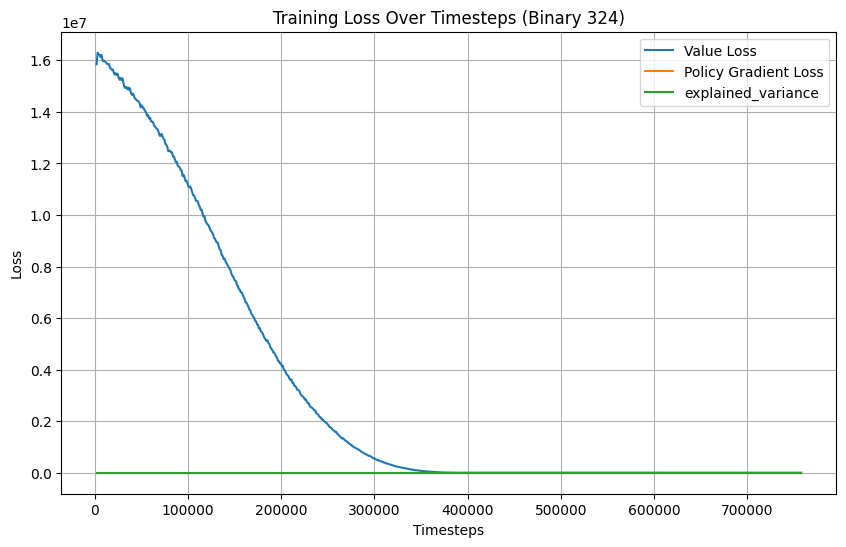

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 로그 데이터 시각화
log_csv_path = os.path.join(log_dir, "progress.csv")  # log_dir은 이전에 정의된 디렉토리 변수

# CSV 파일 읽기 및 그래프 그리기
if os.path.exists(log_csv_path):
    data = pd.read_csv(log_csv_path)

    plt.figure(figsize=(10, 6))
    plt.plot(data["time/total_timesteps"], data["train/value_loss"], label="Value Loss")
    plt.plot(data["time/total_timesteps"], data["train/policy_gradient_loss"], label="Policy Gradient Loss")
    plt.plot(data["time/total_timesteps"], data["train/explained_variance"], label="explained_variance")
    plt.xlabel("Timesteps")
    plt.ylabel("Loss")
    plt.title(f"Training Loss Over Timesteps (Binary {n_machines})")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Log CSV file not found. Ensure training has completed successfully.")